In [1]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import xgboost as xgb
import seaborn as sns
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from termcolor import colored
from cudf_workaround import cudf_groupby_aggs
import matplotlib.pyplot as plt
import os
import time
import warnings
warnings.filterwarnings("ignore")
sns.set()

**This notebook demos the 8th place solution (8/1094) of Rapids.ai for the __[PLAsTiCC Astronomical Classification](https://www.kaggle.com/c/PLAsTiCC-2018/leaderboard)__. The demo shows up to 140x speedup for ETL and 25x end-to-end speedup over the CPU solution. More details can be found at our __[blog](https://medium.com/rapids-ai/make-sense-of-the-universe-with-rapids-ai-d105b0e5ec95)__** 

## Table of contents
[1. Global variables](#global)<br>
[2. Functions](#func)<br>
[3. ETL & Visualizations](#etl)<br>
[4. Model training](#train)<br>
[5. Conclusions](#conclusions)

<a id="global"></a>
## 1. Global variables 

**Original data download and description __[link](https://www.kaggle.com/c/PLAsTiCC-2018/data)__**.

In [2]:
PATH = '../data'

**Tested on V100 with 32 GB GPU memory. If memory capacity is smaller, the input data will be sampled accordingly.**

In [3]:
GPU_MEMORY = 32 # GB. 

In [4]:
TEST_ROWS = 453653104 # number of rows in test data
# no skip if your gpu has 32 GB memory
# otherwise, skip rows porportionally
SKIP_ROWS = int((1 - GPU_MEMORY/32.0)*TEST_ROWS) 
GPU_RUN_TIME = {}
CPU_RUN_TIME = {}

In [5]:
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

<a id="func"></a>
## 2. Functions

In [6]:
def scatter(x,y,values,xlabel='x',ylabel='y',title=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    colors = np.array([colors[i] for i in values])
    ps = []
    bs = []
    bands = ['passband_%s'%i for i in ['u', 'g', 'r', 'i', 'z','y']]
    for i in sorted(np.unique(values)):
        mask = values==i
        if len(x[mask]):
            p = plt.scatter(x[mask],y[mask],c=colors[mask])
            ps.append(p)
            bs.append(bands[i])
    plt.legend(ps,bs,scatterpoints=1)
    if title is not None:
        plt.title(title)
    
    plt.xlim([np.min(x)-10,np.min(x)+1500])
    plt.ylabel('y: %s'%ylabel)
    plt.xlabel('x: %s'%xlabel)

In [7]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    """
    refactor from
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def xgb_multi_weighted_logloss(y_predicted, y_true, classes, class_weights):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted, 
                                  classes, class_weights)
    return 'wloss', loss

### CPU ETL functions 

In [8]:
def ravel_column_names(cols):
    d0 = cols.get_level_values(0)
    d1 = cols.get_level_values(1)
    return ["%s_%s"%(i,j) for i,j in zip(d0,d1)]
    
def etl_cpu(df,df_meta):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    aggs = {
        'passband': ['mean'], 
        'flux': ['min', 'max', 'mean'],
        'flux_err': ['min', 'max', 'mean'],
        'detected': ['mean'],
        'mjd':['max','min'],
        'flux_ratio_sq':['sum'],
        'flux_by_flux_ratio_sq':['sum'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    agg_df.columns = ravel_column_names(agg_df.columns)
    
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df['flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['mjd_max'] - agg_df['mjd_min']
    agg_df = agg_df.drop(['mjd_max','mjd_min'],axis=1)
    
    agg_df = agg_df.reset_index()
    df_meta = df_meta.drop(['ra','decl','gal_l','gal_b'],axis=1)
    df_meta = df_meta.merge(agg_df,on='object_id',how='left')
    return df_meta

### GPU ETL functions 

In [9]:
# To save GPU memory, we drop the column as soon as it is done with groupby
# this hits performance a little but avoids GPU OOM.
def groupby_aggs(df,aggs,col):
    res = None
    for i,j in aggs.items():
        for k in j:
            #print(i,k)
            tmp = df.groupby(col).agg({i:[k]})
            if res is None:
                res = tmp
            else:
                res = res.merge(tmp,on=[col],how='left')
        df.drop_column(i)
    return res

def etl_gpu(df,df_meta):
    aggs = {
        'passband': ['mean'], 
        'detected': ['mean'],
        'mjd':['max','min'],
    }
    agg_df = groupby_aggs(df,aggs,'object_id')
    # at this step, columns ['passband','detected','mjd'] are deleted 
    
    df['flux_ratio_sq'] = df['flux'] / df['flux_err']
    df['flux_ratio_sq'] = df['flux_ratio_sq'].applymap(lambda x: math.pow(x,2))
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs2 = {
        'flux_ratio_sq':['sum'],
        'flux_by_flux_ratio_sq':['sum'],
        'flux': ['min', 'max', 'mean'],
        'flux_err': ['min', 'max', 'mean'],
    }
    agg_df2 = groupby_aggs(df,aggs2,'object_id')
    agg_df = agg_df.merge(agg_df2,on=['object_id'],how='left')
    del agg_df2

    agg_df['flux_diff'] = agg_df['max_flux'] - agg_df['min_flux']
    agg_df['flux_dif2'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['mean_flux']
    agg_df['flux_w_mean'] = agg_df['sum_flux_by_flux_ratio_sq'] / agg_df['sum_flux_ratio_sq']
    agg_df['flux_dif3'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['max_mjd'] - agg_df['min_mjd']
    agg_df.drop_column('max_mjd')
    agg_df.drop_column('min_mjd')
    
    for col in ['ra','decl','gal_l','gal_b']:
        df_meta.drop_column(col)
    
    df_meta = df_meta.merge(agg_df,on=['object_id'],how='left')
    return df_meta

<a id="etl"></a>
## 3. ETL & Visualizations

### Load data for ETL part 1
**GPU load data**

In [10]:
%%time
start = time.time()
step = 'load data part1'
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)
test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 14.1 s, sys: 8.88 s, total: 23 s
Wall time: 23.4 s


**CPU load data**

In [11]:
%%time
start = time.time()
test = pd.read_csv('%s/test_set.csv'%PATH)
train = pd.read_csv('%s/training_set.csv'%PATH)
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 3min 44s, sys: 52.9 s, total: 4min 37s
Wall time: 3min 45s


In [12]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 9.657 speedup for load data part1.


### Visualizations

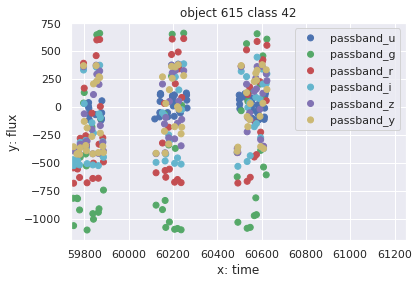

In [13]:
oid = 615
mask = train.object_id== oid
scatter(train.loc[mask,'mjd'].values,
                train.loc[mask,'flux'].values,
                values=train.loc[mask,'passband'].values,
                xlabel='time',ylabel='flux',title='object %d class 42'%oid)

### ETL part 1 with 100x  speedup

In [14]:
%%time
# to save memory, we need to move dataframe to cpu and only keep the columns we need
test_gd = test_gd[['object_id','flux']]
train_gd = train_gd[['object_id','flux']]

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 10.2 ms


In [15]:
%%time
# GPU
step = 'ETL part1'
start = time.time()
aggs = {'flux':['skew']}
test_gd = cudf_groupby_aggs(test_gd,group_id_col='object_id',aggs=aggs)
train_gd = cudf_groupby_aggs(train_gd,group_id_col='object_id',aggs=aggs)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 3.51 s, sys: 1.05 s, total: 4.56 s
Wall time: 5.09 s


In [16]:
%%time
# CPU
start = time.time()
test = test.groupby('object_id').agg(aggs)
train = train.groupby('object_id').agg(aggs)
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 8min 32s, sys: 50.5 s, total: 9min 23s
Wall time: 9min 7s


In [17]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 107.534 speedup for ETL part1.


In [18]:
%%time
test_gd = test_gd.sort_values(by='object_id')
train_gd = train_gd.sort_values(by='object_id')

CPU times: user 24 ms, sys: 24 ms, total: 48 ms
Wall time: 225 ms


In [19]:
%%time
test.columns = ['skew_flux']
test = test.reset_index()
test = test.sort_values(by='object_id')
train.columns = ['skew_flux']
train = train.reset_index()
train = train.sort_values(by='object_id')

CPU times: user 7.3 s, sys: 308 ms, total: 7.6 s
Wall time: 191 ms


**Evaluation of correctness of ETL**

In [20]:
# RMSE: Root mean square error
def rmse(a,b):
    return np.mean((a-b)**2)**0.5
print('test')
for col in test.columns:
    if col in test_gd.columns:
        print("%s, rmse %.6f"%(col,rmse(test[col].values,test_gd[col].to_pandas().values)))
print('train')
for col in train.columns:
    if col in train_gd.columns:
        print("%s, rmse %.6f"%(col,rmse(train[col].values,train_gd[col].to_pandas().values)))

test
object_id, rmse 0.000000
skew_flux, rmse 0.000000
train
object_id, rmse 0.000000
skew_flux, rmse 0.000001


In [21]:
# Rename the variables
test_flux_skew_gd = test_gd
test_flux_skew = test
train_flux_skew_gd = train_gd
train_flux_skew = train
print(len(test_gd),len(test))

3492890 3492890


### Load data for the ETL part 2 with 11x speedup

In [22]:
%%time
# read data on gpu
step = 'load data part2'
start = time.time()
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header
train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)

cols = ['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf',
       'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 
       'distmod','mwebv', 'target']
dtypes = ['int32']+['float32']*4+['int32']+['float32']*5+['int32']

train_meta_gd = gd.read_csv('%s/training_set_metadata.csv'%PATH,
            names=cols,dtype=dtypes,skiprows=1)
del cols[-1],dtypes[-1]
test_meta_gd = gd.read_csv('%s/test_set_metadata.csv'%PATH,
            names=cols,dtype=dtypes,skiprows=1)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 20.7 s, sys: 7.74 s, total: 28.5 s
Wall time: 22.3 s


In [23]:
%%time
# read data on cpu
start = time.time()
test = pd.read_csv('%s/test_set.csv'%PATH)
test_meta = pd.read_csv('%s/test_set_metadata.csv'%PATH)

train = pd.read_csv('%s/training_set.csv'%PATH)
train_meta = pd.read_csv('%s/training_set_metadata.csv'%PATH)
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 4min 5s, sys: 1min 10s, total: 5min 15s
Wall time: 3min 54s


In [24]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 10.515 speedup for load data part2.


### ETL part2 with 9x ~ 12x speedup 

In [25]:
%%time
# GPU
start = time.time()
step = 'ETL part2'
train_final_gd = etl_gpu(train_gd,train_meta_gd)
train_final_gd = train_final_gd.merge(train_flux_skew_gd,on=['object_id'],how='left')
test_final_gd = etl_gpu(test_gd,test_meta_gd)
del test_gd,test_meta_gd
test_final_gd = test_final_gd.merge(test_flux_skew_gd,on=['object_id'],how='left')
GPU_RUN_TIME[step] = time.time() - start

1:int32
2:int32
3:int32
1:int32
1:int32
2:int32
3:float32
1:int32
1:int32
1:float32
2:int32
3:float32
1:float32
2:int32
3:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
1:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:int32
1:int32
1:float32
1:float32
2:int32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
1:int32
1:float32
1:float32
1:float32
1:float32
1:float32
1:int32
2:int32
3:int32
3:int32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
1:int32
1:float32
1:float32
1:float32
1:float32
1:float32
1:int32
1:int32
1:int32
1:float32
1:float32
1:float32
1:float32
1:float32
1:float32
1:floa

In [26]:
%%time
#CPU
start = time.time()
train_final = etl_cpu(train,train_meta)
train_final = train_final.merge(train_flux_skew,on=['object_id'],how='left')
test_final = etl_cpu(test,test_meta)
test_final = test_final.merge(test_flux_skew,on=['object_id'],how='left')
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 4min 5s, sys: 2min 37s, total: 6min 43s
Wall time: 2min 11s


In [27]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 10.496 speedup for ETL part2.


<a id="train"></a>
## 4. Model training

### train and validation with 5x speedup

In [43]:
# CPU
X = train_final.drop(['object_id','target'],axis=1).values
y = train_final['target']
Xt = test_final.drop(['object_id'],axis=1).values
assert X.shape[1] == Xt.shape[1]
classes = sorted(y.unique())    
# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weights = {c: 1 for c in classes}
class_weights.update({c:2 for c in [64, 15]})

lbl = LabelEncoder()
y = lbl.fit_transform(y)
print(lbl.classes_)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y, random_state=126)

[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]


In [44]:
cpu_params = {
            'objective': 'multi:softprob', 
            'tree_method': 'hist', 
            'nthread': 16, 
            'num_class':14,
            'max_depth': 7, 
            'silent':1,
            'subsample':0.7,
            'colsample_bytree': 0.7,}

In [45]:
func_loss = partial(xgb_multi_weighted_logloss, 
                        classes=classes, 
                        class_weights=class_weights)

In [46]:
%%time
start = time.time()
step = 'training'
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
clf = xgb.train(cpu_params, dtrain=dtrain,
                num_boost_round=60,evals=watchlist,
                feval=func_loss,early_stopping_rounds=10,
                verbose_eval=1000)
yp = clf.predict(dvalid)
cpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)
ysub = clf.predict(dtest)
line = 'validation loss %.4f'%cpu_loss
print(colored(line,'green'))
CPU_RUN_TIME[step] = time.time() - start

[07:34:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	eval-merror:0.356688	train-merror:0.276936	eval-wloss:2.04549	train-wloss:1.8956
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.284076	train-merror:0.000991	eval-wloss:1.21854	train-wloss:0.091642
validation loss 1.2185
CPU times: user 6min 47s, sys: 3.08 s, total: 6min 50s
Wall time: 27.2 s


In [47]:
# GPU
y = train_final_gd['target'].to_array()
y = lbl.fit_transform(y)
cols = [i for i in test_final_gd.columns if i not in ['object_id','target']]
for col in cols:
    train_final_gd[col] = train_final_gd[col].fillna(0).astype('float32')

for col in cols:
    test_final_gd[col] = test_final_gd[col].fillna(0).astype('float32')

In [48]:
X = train_final_gd[cols].as_matrix()
Xt = test_final_gd[cols].as_matrix()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y, random_state=126)

In [50]:
# GPU
gpu_params = cpu_params.copy()
gpu_params.update({'objective': 'multi:softprob',
                   'tree_method': 'gpu_hist', 
                  })

In [51]:
%%time
start = time.time()
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
clf = xgb.train(gpu_params, dtrain=dtrain,
                num_boost_round=60,evals=watchlist,
                feval=func_loss,early_stopping_rounds=10,
                verbose_eval=1000)
yp = clf.predict(dvalid)
gpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)
ysub = clf.predict(dtest)
line = 'validation loss %.4f'%gpu_loss
print(colored(line,'green'))
GPU_RUN_TIME[step] = time.time() - start

[0]	eval-merror:0.357962	train-merror:0.298598	eval-wloss:2.02477	train-wloss:1.90594
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.275159	train-merror:0.001699	eval-wloss:1.14549	train-wloss:0.098464
validation loss 1.1455
CPU times: user 1min 30s, sys: 1.77 s, total: 1min 32s
Wall time: 7.39 s


In [52]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 3.683 speedup for training.


<a id="conclusions"></a>
## 5. Conclustions

In [53]:
print("Multiclassification Loss (lower the better):")
print("CPU: %.4f GPU: %.4f"%(cpu_loss,gpu_loss))

Multiclassification Loss (lower the better):
CPU: 1.2185 GPU: 1.1455


In [38]:
CPU_RUN_TIME

{'load data part1': 225.56246209144592,
 'ETL part1': 547.4305279254913,
 'load data part2': 234.0113127231598,
 'ETL part2': 131.0783863067627,
 'training': 26.9383647441864}

In [39]:
GPU_RUN_TIME

{'load data part1': 23.358444452285767,
 'ETL part1': 5.090786457061768,
 'load data part2': 22.255403995513916,
 'ETL part2': 12.488507509231567,
 'training': 7.305835962295532}

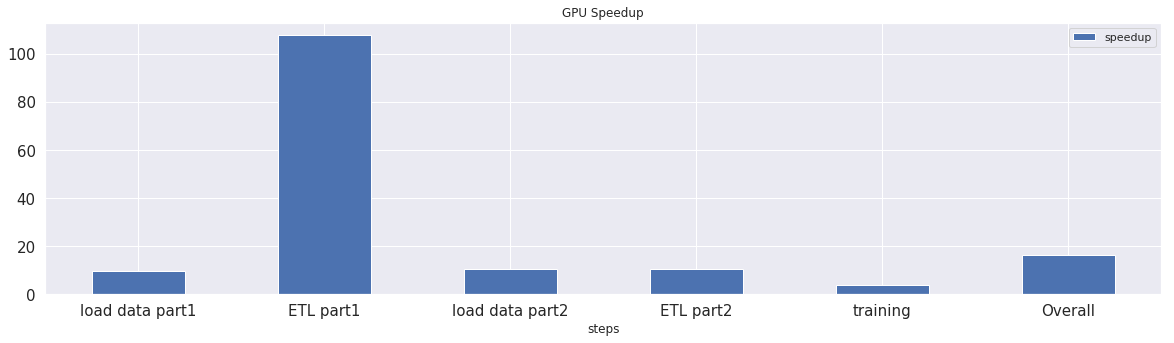

In [40]:
steps = ['load data part1','ETL part1','load data part2','ETL part2','training']
GPU_RUN_TIME['Overall'] = sum([GPU_RUN_TIME[i] for i in steps])
CPU_RUN_TIME['Overall'] = sum([CPU_RUN_TIME[i] for i in steps])
steps.append('Overall')
speedup = [CPU_RUN_TIME[i]/GPU_RUN_TIME[i] for i in steps]
df = pd.DataFrame({'steps':steps, 'speedup':speedup})
df.plot.bar(x='steps', y='speedup', rot=0, figsize=(20,5), fontsize=15, title='GPU Speedup')

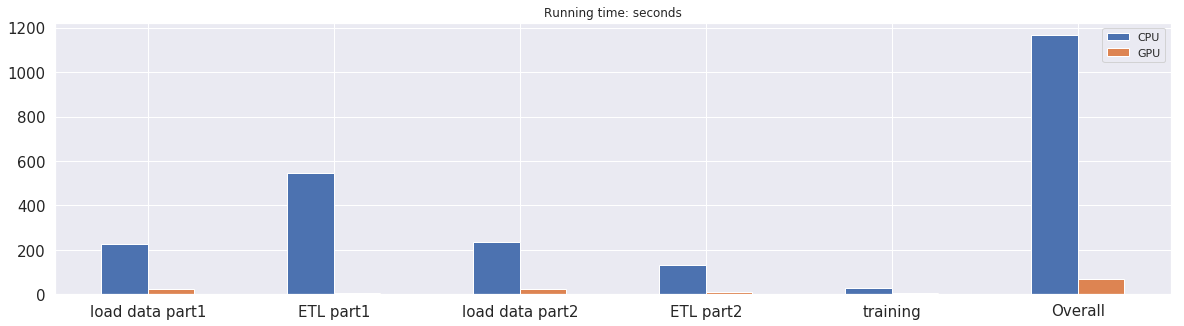

In [41]:
gpu_time = [GPU_RUN_TIME[i] for i in steps]
cpu_time = [CPU_RUN_TIME[i] for i in steps]
df = pd.DataFrame({'GPU': gpu_time,'CPU': cpu_time}, index=steps)
df.plot.bar(rot=0,figsize=(20,5), fontsize=15, title='Running time: seconds')

**The rapids solution achieves up to 140x speedup for ETL and 25x end-to-end speedup over the CPU solution with comparable accuracy.**